In [3]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [4]:
place_name = 'New York City, NY, United States'
place_roads = ox.graph_from_place(place_name)


In [5]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

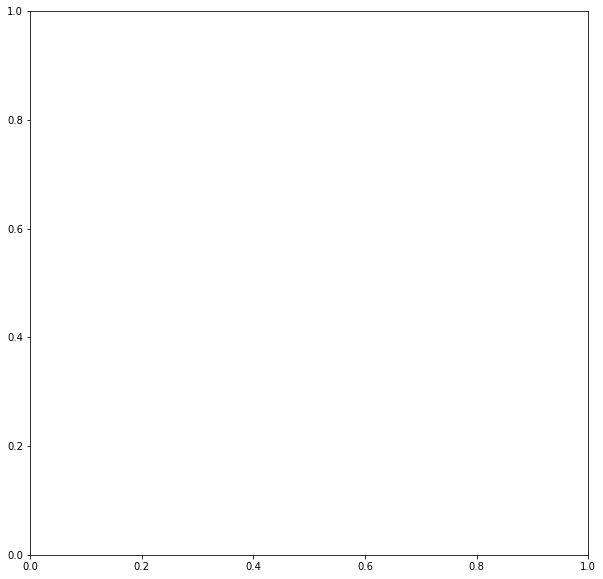

In [4]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
#place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [12]:
place_ice_cream = ox.pois_from_place(place_name, tags={"amenity":"ice_cream"})

#some of the ice cream shops return polygons instead of points, so we need to take their centroids
place_ice_cream = place_ice_cream.to_crs("epsg:3857") #projecting to Web-Mercator for more accurate centroids
place_ice_cream["geometry"] = place_ice_cream["geometry"].centroid
place_ice_cream = place_ice_cream.to_crs("epsg:4326") #projecting back to lat/long


place_ice_cream = place_ice_cream.drop(576014904)


/opt/conda/lib/python3.7/site-packages/osmnx/pois.py:370: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.loc[gdf["geometry"].centroid.within(polygon)]


In [212]:
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

array([  42430886,   42492239,  999184395,   42474968, 7465391419,
       3004844986, 2698702581,   42854333, 6406731704,   42428799,
       4205565536, 5115916405, 5482687360, 4376122105,   42875051,
       4216045804,   42870183,   42466073, 6638433920, 3891969471,
         42469645, 4964127740,   42434959, 6210777837,   42435663,
       6263083540, 6597498400, 5396215013,   42807319,   42876552,
         42439406,   42466011, 7654949115, 7492443638, 7570756477,
         42732035, 4544455461, 3834459546, 5510458199, 4320028830,
         42827392, 5490750794, 7015842113, 2111006220, 6406731684,
         42469492, 4115968602,   42506318,   42438034,   42431712,
         42453226, 4708375542,   42826882, 5830644226, 7229660637,
         42491627, 5159433792,   42807083,   42807108,   42487567,
       5482727326,   42827669,   42885444, 2484549752, 5471772227,
         42497261, 5482174044,   42495404,   42512343, 6369613026,
       3891969467,   42843615, 6814288111, 1372888911, 6816458

In [214]:
ice_cream_nodes.shape

(137,)

## Exercise
Plot the locations of the ice cream shops on the map of the roads

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

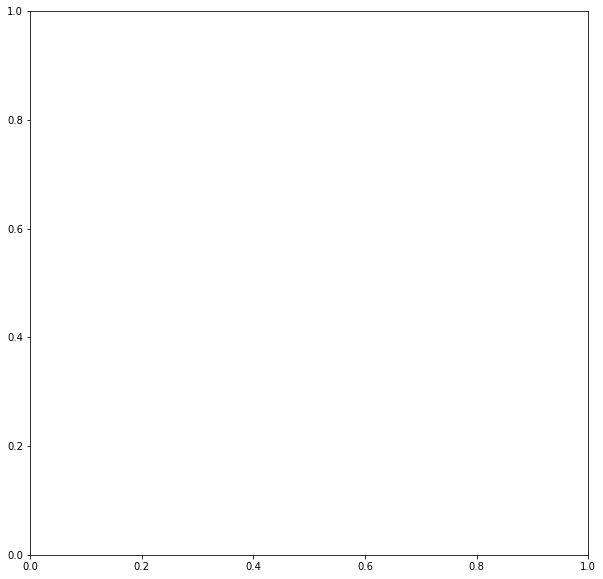

In [7]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
ice_cream_nodes.plot(ax=ax)

#place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)


## Compute shortest path matrix

In [181]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
    shortest_paths = nx.single_source_dijkstra_path_length(place_roads, orig, weight='length')
    for idx_j, dest in enumerate(ice_cream_nodes):
        shortest_path_matrix[idx_i, idx_j] = shortest_paths[dest]
shortest_path_matrix

array([[    0.   ,  5703.569,  4755.273, ...,  7069.604, 13388.496,
          243.69 ],
       [ 5291.002,     0.   ,  2185.151, ..., 12203.158, 14341.679,
         5194.866],
       [ 4694.963,  2337.929,     0.   , ..., 11259.232, 14077.56 ,
         4598.827],
       ...,
       [ 6795.399, 12447.777, 11480.016, ...,     0.   , 13755.4  ,
         6850.159],
       [13426.217, 14433.363, 14048.552, ..., 13547.678,     0.   ,
        13665.726],
       [  243.69 ,  5607.433,  4659.137, ...,  7070.626, 13632.186,
            0.   ]])

In [229]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [238]:
ice_cream_nodes



array([  42430886,   42492239,  999184395,   42474968, 7465391419,
       3004844986, 2698702581,   42854333, 6406731704,   42428799,
       4205565536, 5115916405, 5482687360, 4376122105,   42875051,
       4216045804,   42870183,   42466073, 6638433920, 3891969471,
         42469645, 4964127740,   42434959, 6210777837,   42435663,
       6263083540, 6597498400, 5396215013,   42807319,   42876552,
         42439406,   42466011, 7654949115, 7492443638, 7570756477,
         42732035, 4544455461, 3834459546, 5510458199, 4320028830,
         42827392, 5490750794, 7015842113, 2111006220, 6406731684,
         42469492, 4115968602,   42506318,   42438034,   42431712,
         42453226, 4708375542,   42826882, 5830644226, 7229660637,
         42491627, 5159433792,   42807083,   42807108,   42487567,
       5482727326,   42827669,   42885444, 2484549752, 5471772227,
         42497261, 5482174044,   42495404,   42512343, 6369613026,
       3891969467,   42843615, 6814288111, 1372888911, 6816458

In [237]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})




[42430886,
 42492239,
 999184395,
 42474968,
 7465391419,
 3004844986,
 2698702581,
 42854333,
 6406731704,
 42428799,
 4205565536,
 5115916405,
 5482687360,
 4376122105,
 42875051,
 4216045804,
 42870183,
 42466073,
 6638433920,
 3891969471,
 42469645,
 4964127740,
 42434959,
 6210777837,
 42435663,
 6263083540,
 6597498400,
 5396215013,
 42807319,
 42876552,
 42439406,
 42466011,
 7654949115,
 7492443638,
 7570756477,
 42732035,
 4544455461,
 3834459546,
 5510458199,
 4320028830,
 42827392,
 5490750794,
 7015842113,
 2111006220,
 6406731684,
 42469492,
 4115968602,
 42506318,
 42438034,
 42431712,
 42453226,
 4708375542,
 42826882,
 5830644226,
 7229660637,
 42491627,
 5159433792,
 42807083,
 42807108,
 42487567,
 5482727326,
 42827669,
 42885444,
 2484549752,
 5471772227,
 42497261,
 5482174044,
 42495404,
 42512343,
 6369613026,
 3891969467,
 42843615,
 6814288111,
 1372888911,
 6816458072,
 42487583,
 6450635184,
 42487597,
 42497631,
 42433551,
 42848654,
 42442848,
 1815133244,


In [510]:
short_path_matrix = np.copy(shortest_path_matrix)
short_path_matrix[short_path_matrix == 0] = np.nan
total_distance = 0

In [684]:
path


array([    0.   ,  5703.569,  4755.273,  7135.163,  1318.959,  3245.271,
        5136.848, 19581.712,  8944.752,  9926.134,  2362.672,  6304.018,
        8247.737,   447.311, 13929.52 ,   743.247, 17769.381, 13786.554,
        9366.9  ,  1451.494,  6695.658, 12658.616,  1990.443,  4087.494,
        3866.641,  5135.843,  3732.984, 22807.889, 25473.191, 26267.195,
        5997.664, 12271.577,  7556.517,  6274.956,  6948.569, 25816.078,
        5173.2  ,   579.964, 27366.543,  1374.375,  8745.427, 19007.565,
       20735.467, 17866.532,  8714.184,  5113.982,  1332.021,  5264.447,
        2078.53 ,  1265.616,  9569.865,  6601.539,  5027.524, 16853.633,
       10126.24 ,  6051.725,  1542.008,  9566.411,  9913.697,  7128.837,
        9929.081,  9893.326, 10073.361, 10651.408, 10299.284, 11172.36 ,
        9493.317, 14425.912, 14346.915,  1667.433,  1492.592,  9005.654,
        7405.385,  5594.619, 15593.875,  7843.17 ,  9830.803,  8317.523,
        5544.058,  2375.202, 27214.248,   661.076, 

## Exercise
Implement each of the following methods to see how good of a TSP path you can obtain.

## Method 1: Random
Let's start by setting a baseline; how well can we do by starting at a random node and choosing a random node out of the ones remaining each time? 

After you find the path, draw it on the map and print its length. (You don't need to draw the actual roads taken, just draw lines between the nodes.)

In [692]:
path = list(ice_cream_graph.nodes)
np.random.shuffle(path)
path.append(path[0])
total_length = 0
for idx in range(len(path)-1):
    orig = path[idx]
    dest = path[idx+1]
    length = ice_cream_graph.get_edge_data(orig, dest, 0)['weight']
    total_length += length
print(total_length)

2014226.980999999


## Method 2: Greedy
Now, let's try to choose nodes more intelligently: start at a random node again, but instead of choosing a random node each time, always choose the node closest to the current node each time.

Again, draw the path on the map and print its length.

In [676]:
short_path_matrix, short_path_matrix[short_path_matrix == 0], total_distance, starting_node = np.copy(shortest_path_matrix), np.nan, 0, np.random.randint(0, 136)
start = starting_node
list_of_index_used = [starting_node]

for i in range(136):
    if i == 135:
        Return = shortest_path_matrix[index_v][start]
    total_distance += np.nanmin(short_path_matrix[starting_node])
    index_v = short_path_matrix[starting_node].tolist().index(np.nanmin(short_path_matrix[starting_node]))
    list_of_index_used.append(index_v)
    short_path_matrix[index_v][short_path_matrix[index_v] == np.nanmin(short_path_matrix[starting_node])] = np.nan
    short_path_matrix[index_v] = short_path_matrix[index_v]
    starting_node = index_v
    for i in list_of_index_used:
        short_path_matrix[index_v][i] = np.nan
total_distance = total_distance + Return
print(total_distance)

354522.6519999998


## Method 3: Random with 2-opt swapping

You may have noticed that both paths contain a lot of edges that cross each other, which is nonideal. However, there exists an algorithm to remove all the paths that cross each other from a Hamiltonian cycle: the [2-opt](https://en.wikipedia.org/wiki/2-opt) algorithm. We can use that to our advantage here.

Start by generating a random Hamiltonian cycle like in method 1, but this time, use the 2-opt algorithm to optimize it further. Again, draw it on the map and print its length.

In [677]:
def twoopt(route, i, k):
    
    
    
    

## Method 4: Open-ended

Although the 2-opt swaps reduce the length of the Hamiltonian cycle by quite a lot, they almost never provide the optimal solution. See if you can use another method to produce a Hamiltonian cycle shorter than the one you got with method 3. Some options to explore include:

- [3-opt](https://en.wikipedia.org/wiki/3-opt)
- [Multi-fragment algorithm](https://en.wikipedia.org/wiki/Multi-fragment_algorithm) with 2- or 3-opt swapping
- [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)

The [TSP Wikipedia page](https://en.wikipedia.org/wiki/Travelling_salesman_problem) has many other algorithms that could be of use to you as well.
